# Neural Network Sounding Integration
David John Gagne

The goal of this notebook is to provide an introductory example showing how deep learning could be used to 
calculate information on a thermodynamic diagram.

In [290]:
%matplotlib inline
import numpy as np
import pandas as pd
from metpy.calc import dry_lapse, moist_lapse, saturation_mixing_ratio
from metpy.plots import SkewT
import pint
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Activation, Conv1D, AveragePooling1D, Reshape, Flatten, Dropout, AlphaDropout, LeakyReLU
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD
from metpy.constants import Cp_d, epsilon, g, kappa, Lv, P0, Rd
from metpy.calc.thermo import *


The moist adiabat or pseudo-adiabat is the temperature trajectory taken by a saturated parcel as it ascends in the 
atmosphere. The change in temperature with pressue, or moist adiabatic lapse rate is 

\begin{equation}
\frac{dT}{dP} = \frac{1}{P} \frac{R_d T + L_v r_s}{C_{pd} + \frac{L_v^2 r_s \epsilon}{R_d T^2}}
\end{equation}

The equation does not have an analytic solution and must be integrated numerically. We do this below for a range of temperatures and a fixed set of pressure values.

In [12]:
ureg = pint.UnitRegistry()
train_temps = np.arange(230, 330, 2) * ureg.K
test_temps = np.arange(231, 331, 2) * ureg.K
pressures = np.arange(100, 1020, 20)[::-1] * ureg.hPa
print(train_temps.shape, pressures.shape)

(50,) (46,)


In [83]:
train_data = np.zeros((train_temps.size, pressures.size))
test_data = np.zeros((test_temps.size, pressures.size))
for t, temp in enumerate(train_temps):
    print(temp)
    train_data[t] = moist_lapse(pressures, temp)
for t, temp in enumerate(test_temps):
    print(temp)
    test_data[t] = moist_lapse(pressures, temp)

230 kelvin
232 kelvin
234 kelvin
236 kelvin
238 kelvin
240 kelvin
242 kelvin
244 kelvin
246 kelvin
248 kelvin
250 kelvin
252 kelvin
254 kelvin
256 kelvin
258 kelvin
260 kelvin
262 kelvin
264 kelvin
266 kelvin
268 kelvin
270 kelvin
272 kelvin
274 kelvin
276 kelvin
278 kelvin
280 kelvin
282 kelvin
284 kelvin
286 kelvin
288 kelvin
290 kelvin
292 kelvin
294 kelvin
296 kelvin
298 kelvin
300 kelvin
302 kelvin
304 kelvin
306 kelvin
308 kelvin
310 kelvin
312 kelvin
314 kelvin
316 kelvin
318 kelvin
320 kelvin
322 kelvin
324 kelvin
326 kelvin
328 kelvin
231 kelvin
233 kelvin
235 kelvin
237 kelvin
239 kelvin
241 kelvin
243 kelvin
245 kelvin
247 kelvin
249 kelvin
251 kelvin
253 kelvin
255 kelvin
257 kelvin
259 kelvin
261 kelvin
263 kelvin
265 kelvin
267 kelvin
269 kelvin
271 kelvin
273 kelvin
275 kelvin
277 kelvin
279 kelvin
281 kelvin
283 kelvin
285 kelvin
287 kelvin
289 kelvin
291 kelvin
293 kelvin
295 kelvin
297 kelvin
299 kelvin
301 kelvin
303 kelvin
305 kelvin
307 kelvin
309 kelvin
311 kelvin

In [14]:
l_mean = train_data.mean(axis=0)
l_sd = train_data.std(axis=0)
t_mean = train_temps.m.mean()
t_sd = train_temps.m.std()
norm_train_data = (train_data - l_mean) / l_sd
norm_train_input = (train_temps.m.reshape(-1, 1) - t_mean) / t_sd
norm_test_input = (test_temps.m.reshape(-1, 1) - t_mean) / t_sd

In [296]:
nn_moist_in = Input(shape=(1,))
nn_moist_lapse = Dense(46 * 4,)(nn_moist_in)
nn_moist_lapse = LeakyReLU(0.1)(nn_moist_lapse)
nn_moist_lapse = Reshape((46 * 4, 1))(nn_moist_lapse)
nn_moist_lapse = Conv1D(16, 5, padding="same")(nn_moist_lapse)
nn_moist_lapse = LeakyReLU(0.1)(nn_moist_lapse)
nn_moist_lapse = AveragePooling1D()(nn_moist_lapse)
nn_moist_lapse = Conv1D(24, 5, padding="same")(nn_moist_lapse)
nn_moist_lapse = LeakyReLU(0.1)(nn_moist_lapse)
nn_moist_lapse = AveragePooling1D()(nn_moist_lapse)
nn_moist_lapse = Conv1D(32, 5, padding="same")(nn_moist_lapse)
nn_moist_lapse = LeakyReLU(0.1)(nn_moist_lapse)
nn_moist_lapse = Conv1D(1, 5, padding="same")(nn_moist_lapse)
nn_moist_lapse = Flatten()(nn_moist_lapse)
nn_moist_mod = Model(nn_moist_in, nn_moist_lapse)
opt = SGD(lr=0.001, momentum=0.99, decay=1e-6, nesterov=True)
nn_moist_mod.compile("adam", "mse")

In [285]:
nn_moist_mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_90 (Dense)             (None, 184)               368       
_________________________________________________________________
reshape_17 (Reshape)         (None, 184, 1)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 184, 16)           96        
_________________________________________________________________
average_pooling1d_28 (Averag (None, 92, 16)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 92, 24)            1944      
_________________________________________________________________
average_pooling1d_29 (Averag (None, 46, 24)            0         
__________

In [297]:
nn_moist_mod.fit(norm_train_input, norm_train_data, epochs=500,batch_size=5)

Epoch 1/500
50/50 [==============================] - 0s - loss: 1.0025     
Epoch 2/500
50/50 [==============================] - 0s - loss: 0.9908     
Epoch 3/500
50/50 [==============================] - 0s - loss: 0.9686     
Epoch 4/500
50/50 [==============================] - 0s - loss: 0.8758     
Epoch 5/500
50/50 [==============================] - 0s - loss: 0.6228     
Epoch 6/500
50/50 [==============================] - 0s - loss: 0.3613     
Epoch 7/500
50/50 [==============================] - 0s - loss: 0.1985     
Epoch 8/500
50/50 [==============================] - 0s - loss: 0.1369     
Epoch 9/500
50/50 [==============================] - 0s - loss: 0.0917     
Epoch 10/500
50/50 [==============================] - 0s - loss: 0.0664     
Epoch 11/500
50/50 [==============================] - 0s - loss: 0.0537     
Epoch 12/500
50/50 [==============================] - 0s - loss: 0.0507     
Epoch 13/500
50/50 [==============================] - 0s - loss: 0.0455     
Epoch 14

50/50 [==============================] - 0s - loss: 9.3900e-04     
Epoch 107/500
50/50 [==============================] - 0s - loss: 8.6306e-04     
Epoch 108/500
50/50 [==============================] - 0s - loss: 9.7012e-04     
Epoch 109/500
50/50 [==============================] - 0s - loss: 8.7211e-04     
Epoch 110/500
50/50 [==============================] - 0s - loss: 8.2063e-04     
Epoch 111/500
50/50 [==============================] - 0s - loss: 8.4548e-04     
Epoch 112/500
50/50 [==============================] - 0s - loss: 8.4234e-04     
Epoch 113/500
50/50 [==============================] - 0s - loss: 8.3152e-04     
Epoch 114/500
50/50 [==============================] - 0s - loss: 7.2001e-04     
Epoch 115/500
50/50 [==============================] - 0s - loss: 7.1898e-04     
Epoch 116/500
50/50 [==============================] - 0s - loss: 7.3957e-04     
Epoch 117/500
50/50 [==============================] - 0s - loss: 6.6625e-04     
Epoch 118/500
50/50 [=========

50/50 [==============================] - 0s - loss: 4.2652e-04     
Epoch 207/500
50/50 [==============================] - 0s - loss: 3.2714e-04     
Epoch 208/500
50/50 [==============================] - 0s - loss: 2.5145e-04     
Epoch 209/500
50/50 [==============================] - 0s - loss: 2.4544e-04     
Epoch 210/500
50/50 [==============================] - 0s - loss: 2.3658e-04     
Epoch 211/500
50/50 [==============================] - 0s - loss: 2.5982e-04     
Epoch 212/500
50/50 [==============================] - 0s - loss: 2.5750e-04     
Epoch 213/500
50/50 [==============================] - 0s - loss: 2.6585e-04     
Epoch 214/500
50/50 [==============================] - 0s - loss: 2.3055e-04     
Epoch 215/500
50/50 [==============================] - 0s - loss: 2.3492e-04     
Epoch 216/500
50/50 [==============================] - 0s - loss: 2.6619e-04     
Epoch 217/500
50/50 [==============================] - 0s - loss: 3.6358e-04     
Epoch 218/500
50/50 [=========

50/50 [==============================] - 0s - loss: 0.0010         
Epoch 307/500
50/50 [==============================] - 0s - loss: 0.0010     
Epoch 308/500
50/50 [==============================] - 0s - loss: 6.2367e-04     
Epoch 309/500
50/50 [==============================] - 0s - loss: 4.3657e-04     
Epoch 310/500
50/50 [==============================] - 0s - loss: 5.3147e-04     
Epoch 311/500
50/50 [==============================] - 0s - loss: 6.3534e-04     
Epoch 312/500
50/50 [==============================] - 0s - loss: 4.8613e-04     
Epoch 313/500
50/50 [==============================] - 0s - loss: 4.6632e-04     
Epoch 314/500
50/50 [==============================] - 0s - loss: 5.1928e-04     
Epoch 315/500
50/50 [==============================] - 0s - loss: 4.0766e-04     
Epoch 316/500
50/50 [==============================] - 0s - loss: 3.1295e-04     
Epoch 317/500
50/50 [==============================] - 0s - loss: 1.5869e-04     
Epoch 318/500
50/50 [=============

50/50 [==============================] - 0s - loss: 9.1602e-05     
Epoch 407/500
50/50 [==============================] - 0s - loss: 1.0439e-04     
Epoch 408/500
50/50 [==============================] - 0s - loss: 1.5231e-04     
Epoch 409/500
50/50 [==============================] - 0s - loss: 2.2874e-04     
Epoch 410/500
50/50 [==============================] - 0s - loss: 2.8399e-04     
Epoch 411/500
50/50 [==============================] - 0s - loss: 8.7380e-04     
Epoch 412/500
50/50 [==============================] - 0s - loss: 4.8638e-04     
Epoch 413/500
50/50 [==============================] - 0s - loss: 8.3462e-04     
Epoch 414/500
50/50 [==============================] - 0s - loss: 4.5237e-04     
Epoch 415/500
50/50 [==============================] - 0s - loss: 3.1885e-04     
Epoch 416/500
50/50 [==============================] - 0s - loss: 2.1449e-04     
Epoch 417/500
50/50 [==============================] - 0s - loss: 2.3494e-04     
Epoch 418/500
50/50 [=========

In [298]:
nn_moist_preds = (nn_moist_mod.predict(norm_test_input) * l_sd + l_mean) * ureg.K

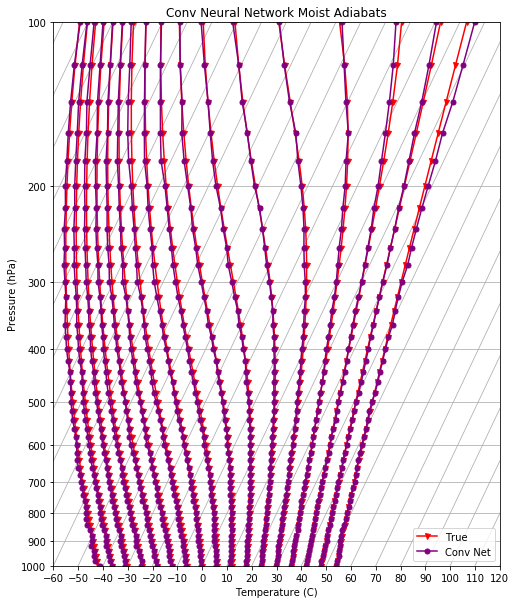

In [302]:
fig = plt.figure(figsize=(8, 10))
sk = SkewT(fig=fig, rotation=30)
sk.ax.set_xlim(-60, 120)
sk.ax.set_ylim(1000, 100)
for p in range(0, nn_moist_preds.shape[0], 3):
    if p == 0:
        label = "True"
    else:
        label = None
    sk.plot(pressures, (test_data[p]* ureg.K).to("degC"), color="red", label=label, marker='v', ms=5)
for p in range(0, nn_moist_preds.shape[0], 3):
    if p == 0:
        label = "Conv Net"
    else:
        label = None
    sk.plot(pressures, nn_moist_preds[p].to("degC"), color="purple", label=label, marker='o', ms=5)
plt.legend()
plt.xlabel("Temperature (C)")
plt.ylabel("Pressure (hPa)")
plt.title("Conv Neural Network Moist Adiabats")
plt.savefig("conv_net_adiabats.pdf", dpi=200, bbox_inches="tight")

In [108]:
def dt(t, p):
    rs = saturation_mixing_ratio(p, t)
    frac = ((Rd * t + Lv * rs) /
            (Cp_d + (Lv * Lv * rs * epsilon / (Rd * t * t)))).to('kelvin')
    return frac / p

In [124]:
temps_dt = np.arange(230, 350, 2)
pres_dt = np.arange(100, 1020, 20)
temp_grid, pres_grid = np.meshgrid(temps_dt, pres_dt)
dt_grid = np.zeros(temp_grid.shape)
print(dt_grid.shape)
for (i, j), t in np.ndenumerate(temp_grid):
    dt_grid[i, j] = dt(units.Quantity(temp_grid[i, j], "kelvin"), 
                       units.Quantity(pres_grid[i, j], "hPa")).m

(46, 60)


In [257]:
nn_lapse_input = Input(shape=(2,))
nn_lapse = Dense(20, activation="tanh")(nn_lapse_input)
nn_lapse = Dense(20, activation="tanh")(nn_lapse)
nn_lapse = Dense(1)(nn_lapse)
nn_lapse_mod = Model(nn_lapse_input, nn_lapse)
opt = SGD(lr=0.001, momentum=0.99, decay=1e-6, nesterov=True)
nn_lapse_mod.compile(opt, "mse")


In [214]:
lapse_train_data = pd.DataFrame({"temp": temp_grid.ravel(), "pres": pres_grid.ravel(), "lapse": dt_grid.ravel()})
norms = pd.DataFrame(index=lapse_train_data.columns, columns=["mean", "sd"], dtype=float)
for col in lapse_train_data.columns:
    norms.loc[col, "mean"] = lapse_train_data[col].mean()
    norms.loc[col, "sd"] = lapse_train_data[col].std()
    lapse_train_data[col + "_norm"] = (lapse_train_data[col] - norms.loc[col, "mean"]) / norms.loc[col, "sd"]


In [267]:
nn_lapse_mod.fit(lapse_train_data[["temp_norm", "pres_norm"]].values, lapse_train_data["lapse"].values, epochs=100, batch_size=8)

Epoch 1/100
2760/2760 [==============================] - 0s - loss: 2.5946e-04     
Epoch 2/100
2760/2760 [==============================] - 0s - loss: 2.5334e-04     
Epoch 3/100
2760/2760 [==============================] - 0s - loss: 2.4986e-04     
Epoch 4/100
2760/2760 [==============================] - 0s - loss: 2.4147e-04     
Epoch 5/100
2760/2760 [==============================] - 0s - loss: 2.3440e-04     
Epoch 6/100
2760/2760 [==============================] - 0s - loss: 2.2913e-04     
Epoch 7/100
2760/2760 [==============================] - 0s - loss: 2.3300e-04     
Epoch 8/100
2760/2760 [==============================] - 0s - loss: 2.3282e-04     
Epoch 9/100
2760/2760 [==============================] - 0s - loss: 2.2562e-04     
Epoch 10/100
2760/2760 [==============================] - 0s - loss: 2.1956e-04     
Epoch 11/100
2760/2760 [==============================] - 0s - loss: 2.1264e-04     
Epoch 12/100
2760/2760 [==============================] - 0s - loss: 2.200

2760/2760 [==============================] - 0s - loss: 9.5346e-05     
Epoch 98/100
2760/2760 [==============================] - 0s - loss: 8.9899e-05     
Epoch 99/100
2760/2760 [==============================] - 0s - loss: 9.0696e-05     
Epoch 100/100
2760/2760 [==============================] - 0s - loss: 9.0016e-05     


In [268]:
lapse_preds = nn_lapse_mod.predict(lapse_train_data[["temp_norm", "pres_norm"]].values)

(array([  8.89000000e+02,   1.10200000e+03,   3.97000000e+02,
          1.82000000e+02,   7.80000000e+01,   4.90000000e+01,
          3.20000000e+01,   2.00000000e+01,   1.00000000e+01,
          1.00000000e+00,   0.00000000e+00]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55]),
 <a list of 1 Patch objects>)

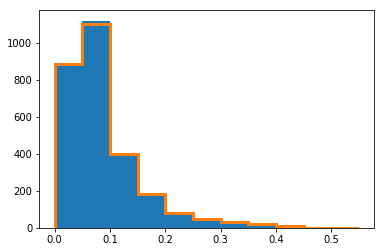

In [269]:
plt.hist(lapse_train_data["lapse"].values, bins=np.arange(0, 0.6, 0.05))
plt.hist(lapse_preds, bins=np.arange(0, 0.6, 0.05), histtype="step", lw=3)


In [181]:
pressures

<Quantity([1000  980  960  940  920  900  880  860  840  820  800  780  760  740  720
  700  680  660  640  620  600  580  560  540  520  500  480  460  440  420
  400  380  360  340  320  300  280  260  240  220  200  180  160  140  120
  100], 'hectopascal')>

In [270]:
nn_temps = np.zeros(test_data.shape)
print(nn_temps.shape)
for t, temp in enumerate(test_temps):
    nn_temps[t, 0] = temp.m
    norm_temp = (temp.m - norms.loc["temp", "mean"]) / norms.loc["temp", "sd"]
    curr_temp = temp.m
    pres = pressures.m[0]
    p = 1
    while pres > pressures.m.min():
        norm_pres = (pres - norms.loc["pres", "mean"]) / norms.loc["pres", "sd"]
        lapse = nn_lapse_mod.predict(np.array([[norm_temp, norm_pres]]))
        curr_temp -= lapse * 4
        if pres in pressures.m:
            nn_temps[t, p] = curr_temp
            p += 1
        pres -= 4
        norm_temp = (curr_temp - norms.loc["temp", "mean"]) / norms.loc["temp", "sd"]

(50, 46)


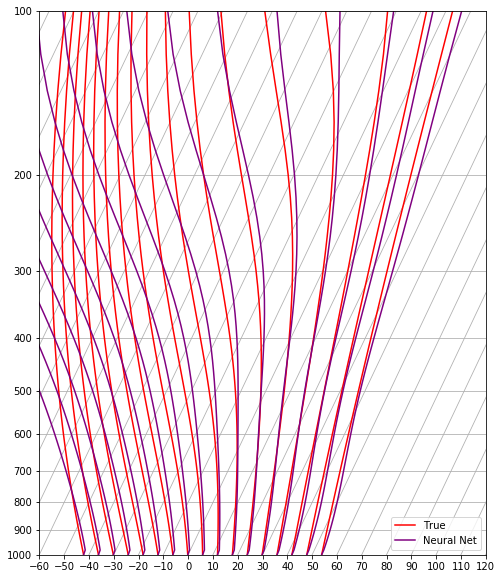

In [271]:
fig = plt.figure(figsize=(8, 10))
sk = SkewT(fig=fig, rotation=30)
sk.ax.set_xlim(-60, 120)
sk.ax.set_ylim(1000, 100)
for p in range(0, nn_moist_preds.shape[0], 3):
    if p == 0:
        label = "True"
    else:
        label = None
    sk.plot(pressures, (test_data[p]* ureg.K).to("degC"), color="red", label=label)
for p in range(0, nn_moist_preds.shape[0], 3):
    if p == 0:
        label = "Neural Net"
    else:
        label = None
    sk.plot(pressures, (nn_temps[p] * ureg.K).to("degC"), color="purple", label=label)
plt.legend()

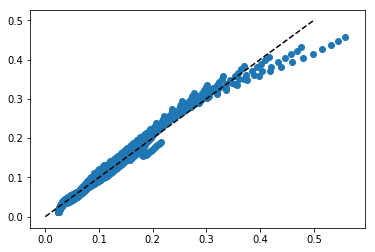

In [272]:
plt.scatter(lapse_train_data["lapse"], lapse_preds)
plt.plot(np.arange(0, 0.6, 0.1), np.arange(0, 0.6, 0.1), 'k--')

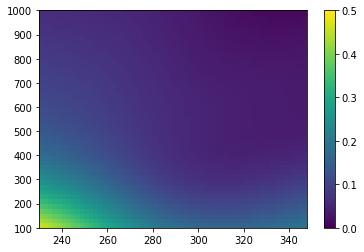

In [273]:
plt.pcolormesh(temps_dt, pres_dt, lapse_preds.reshape(temp_grid.shape), vmin=0, vmax=0.5)
plt.colorbar()

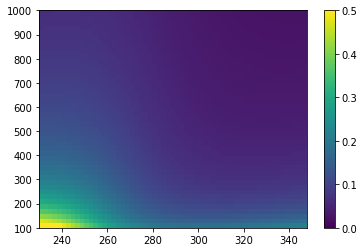

In [274]:
plt.pcolormesh(temps_dt, pres_dt, dt_grid, vmin=0, vmax=0.5)
plt.colorbar()

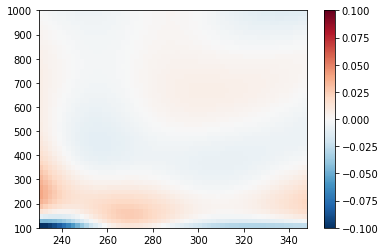

In [275]:
plt.pcolormesh(temps_dt, pres_dt, lapse_preds.reshape(temp_grid.shape) - dt_grid, cmap="RdBu_r", vmin=-0.1, vmax=0.1)
plt.colorbar()